## CHEME 5660 Actual Prelim 2 Equity Question

You are a Quant at Olin Financial, an up-and-coming hedge fund. You have been tasked with computing the distribution of possible future share price values for firm XYZ.
Suppose the share price of firm XYZ at time $t$, denoted by $S(t)$, is governed by a geometric Brownian motion with the solution:

$$
\begin{equation}\label{eqn-gbm-anal-soln}
S(t) = S_{\circ}\exp\left(\left(\mu - \frac{\sigma^{2}}{2}\right)\left(t-t_{\circ}\right)+\sigma\sqrt{t-t_{\circ}}\cdot{Z(0,1)}\right)
\end{equation}
$$

where $S_{\circ}$ denotes the initial share price at $t_{\circ}<t$, $\mu$ denotes the rate of return parameter, 
$\sigma>0$ denotes the volatility parameter and $Z\left(0,1\right)$ denotes a standard-normal random variable. 

__Assumptions__: (i) the implied volatility of an At the Money (ATM) `01/20/2023` option on XYZ is 52.27\%; 
(ii) there are 78 days to 01/20/2023 (from today); (iii) the current share price of XYZ is 270.89 USD/share.

Use the Jupyter notebook `CHEME-5660-PP2-Equity.ipynb`, and any associated data sets, or other course materials to answer the following questions:

* a) Estimate the rate of return parameter $\mu$ from historical OHLC data for firm XYZ.
* b) Estimate the volatility parameter $\sigma$ from historical OHLC data for firm XYZ.
* c) Using your estimates of the $\mu$ and $\sigma$ parameters, along with the analytical GBM solution, estimate a distribution of possible future share price values of XYZ on `01/20/2023`. Generate N = 10,000 sample paths and let $t_{\circ} = 0$ (now).

## Solution

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/CHEME-5660-Markets-Mayhem-Example-Notebooks-main/prelims/P2/actual`
  No Changes to `~/Desktop/CHEME-5660-Markets-Mayhem-Example-Notebooks-main/prelims/P2/actual/Project.toml`
  No Changes to `~/Desktop/CHEME-5660-Markets-Mayhem-Example-Notebooks-main/prelims/P2/actual/Manifest.toml`


In [2]:
# load external packages that are required for the calculations -
using DataFrames
using CSV
using Dates
using Statistics
using LinearAlgebra
using Plots
using Colors
using Distributions
using StatsPlots

# setup paths to load XYZ OHLC data set -
const _NOTEBOOK_ROOT = pwd();
const _PATH_TO_DATA = joinpath(_NOTEBOOK_ROOT, "data");

In [3]:
include("CHEME-5560-AP2-CodeLib.jl"); # Look inside me to find out what I have!

In [4]:
# load the OHLC data set -
df = CSV.read(joinpath(_PATH_TO_DATA, "CHEME-5660-OHLC-XYZ-AP2-F22.csv"), DataFrame);

In [5]:
# setup constants -
ΔT = 78.0;             # days to expiration (units: days)
B = 365.0;             # number of days per year
IV = 52.27;            # implied volatility
Sₒ = 270.89;           # initial share price given in the problem

# plot and sim constants stuff for later -
number_of_bins = 80;
number_of_sample_paths = 10000;

#### Split the historical data into training and prediction sets

In [6]:
α = 0.75; # fraction of data for training (you get to choose this)

In [7]:
# instead of using all the data from 1 - let's specify a start index -
start_index = 250; #  you also get to choose this! (1 -> all data)
#ASSUMPTIONS:
#rational for 250: 2020 was such a bizzare time think it is fair to start closer to 2021
#However experience a hard crash in early 2022 but feel that is notable to include (perhaps went from a stable company to a volatile one)
#therefore, I am interested in tracking the behavior of the stock from slightly before the crash onward.


df_local = df[start_index:end, :]

N = nrow(df_local); # this is the number of rows in the total data set -
ℒ = Int64(round(α*N));

# split the data into to two chunks, training and validation
all_range = range(1,stop=N,step=1) |> collect
T_all = all_range*(1.0/365.0) .- (1.0/365.0)

# time ranges for the training, and prediction sets
training_range = range(1,stop=ℒ, step=1);
prediction_range = range(ℒ+1,stop=N, step=1);

# data sets -
df_training = df_local[training_range,:];
df_prediction = df_local[prediction_range,:];

In [8]:
# build an empty model, add stuff to it -
training_model = GeometricBrownianMotionModel()
training_model.T₁ = 0.0
training_model.T₂ = 0.0;
training_model.h = (1.0/365.0)
training_model.Xₒ = df_local[1,:close]; # we can change where we start 

# parameter values -
training_model.μ = 0.0; # we don't know this value yet, 0 for now
training_model.σ = 0.0; # we don't know this value yet, 0 for now

### a) Estimate the rate of return parameter $\mu$

#### Strategy
Let $A$ denote the $\mathcal{S}\times{2}$ matrix holding the time values; the first column of $A$ is all 1's while the second column holds the $(t-t_{\circ})$ values. Further, let $Y$ denote the QQQ close price values (in the same order as the $A$ matrix). Then, the y-intercept and slope can be estimated by solving the `overdetermined` system of equations:

$$A\theta = Y$$

where $\theta$ denotes a $2\times{1}$ vector of unknown parameters; the first element is the y-intercept $b=\ln{S_{\circ}}$ while the second element is $\hat{\mu}$, an estimate of the growth-rate parameter. This system can be solved as:

$$\theta = (A^{T}A)^{-1}A^{T}Y$$

where $A^{T}$ denotes the transpose of the matrix $A$. 

In [9]:
# fill me in ...

# Setup the normal equations -

#XD is your A matrix with 1's in col 1 and (t-t0) values in col 2
XD = [ones(Int64(round(α*N))) T_all[training_range]];
#print(XD)

# P̂ is your Y matrix with 1's in col 1 and close price data of firm XYZ in col 2
P̂ = log.(df_training[!,:close]);
#print(P̂)


P̂_prediction = log.(df_prediction[!,:close]);
#print(P̂_prediction)


# Solve the normal equations -

# θ is your 2 x 1 centor matrick of unknown parameters 
θ = inv(transpose(XD)*XD)*transpose(XD)*P̂;
print(θ)

# get estimated μ -
μ̂ = θ[2];
print(μ̂)

# update the training model -
training_model.μ = 1.0*μ̂;

# compute model -
b = θ[1];
P̂_model = b .+ μ̂*T_all;
#print(P̂_model)

[6.674868502794293, -2.9839043654085344]-2.9839043654085344

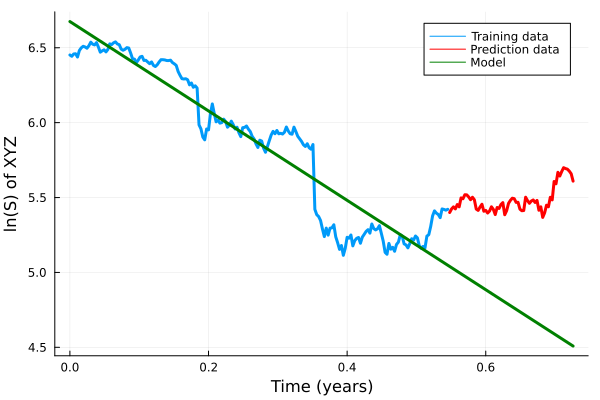

In [10]:
# check: it sure would be nice to see you soln against the data ...

plot(T_all[training_range], P̂, label="Training data", lw=3)
plot!(T_all[prediction_range], P̂_prediction, lw=3, c=:red, label="Prediction data")
plot!(T_all, P̂_model, lw=3, c=:green, label="Model")

xlabel!("Time (years)", fontsize=18)
ylabel!("ln(S) of XYZ", fontsize=18)

#KEY HERE: Need to sit with group and figure out how much of the data you really want to take? 
# different amounts give you different fits of your model 
# as well, just go back and double check and make sure you are understanding every line.

### b) Estimate the volatility parameter $\sigma$

#### Strategy

To construct an estimate of the volatility parameter $\hat{\sigma}$ we try to match the model estimated variance:

$$\text{Var}\left(S_{t}\right) = S_{\circ}^{2}e^{2\mu{(t-t_{\circ})}}\left[e^{\sigma^{2}{(t-t_{\circ})}} - 1\right]$$

with the variance in the price data; where we let $\mu=\hat{\mu}$ and the variance $\text{Var}\left(X_{t}\right)$ is calculated by using the [implied volatility (IV)](https://www.investopedia.com/terms/i/iv.asp). The [implied volatility (IV)](https://www.investopedia.com/terms/i/iv.asp) gives the market estimate of the standard deviation of the price T-days in the future:

$$\sigma_{IV} = S_{\circ}\times\left(\frac{IV}{100}\right)\times\left(\sqrt{\frac{T}{365}}\right)$$

However, $\sigma^{2}_{IV}(t)\simeq{\text{Var}\left(X_{t}\right)}$; thus, we can solve the variance expression for $\sigma$:

$$\sigma^{2} = \frac{1}{T^{\prime}}\times\ln\left(\frac{\text{Var}\left(S_{T^{\prime}}\right)}{S_{\circ}^{2}e^{2\mu{T^{\prime}}}} + 1\right)$$

where:

$$T^{\prime} = \frac{1}{365}\left(T - T_{\circ}\right)$$

In [11]:
# estimate the volatility σ̂ -
# fill me in
Sₒ = df_local[1,:close]; # initial share price
N_local = length(df_local[1,:close]);
Var_market = (Sₒ*(IV/100.0)*sqrt(N_local/365))^2 # variance of price using the IV -
T_market = (N_local/365.0)
a = Var_market/((Sₒ^2)*exp(2*μ̂*T_market)) + 1
σ̂ = sqrt((1/T_market)*log(a))

0.5268904266602527

### c) Predict share price distribution of `XYZ` T = 78 days into the future

In [12]:
# build new prediction model -
future_prediction_model = GeometricBrownianMotionModel()
future_prediction_model.T₁ = 0.0
future_prediction_model.T₂ = (ΔT/B);
future_prediction_model.h = (1.0/365.0)
future_prediction_model.Xₒ = Sₒ; # share price from the problem

# parameter values -
future_prediction_model.μ = -2.9839043654085344; # replace this with your estimated value
future_prediction_model.σ = 0.5268904266602527; # replace this with your estimated value

In [13]:
# run simulation using the solve function in the code library
# fill me in ...
future_prediction = solve(future_prediction_model; 𝒫 = 10000);

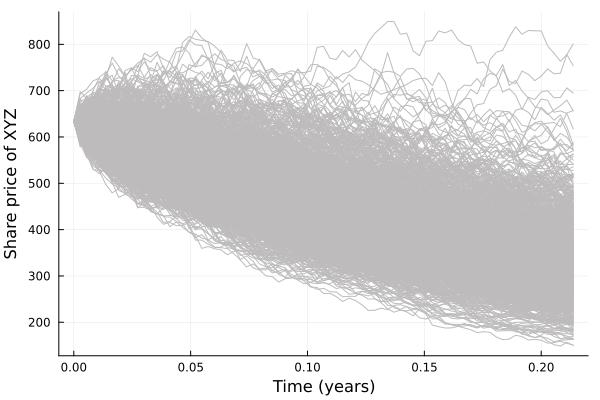

In [14]:
# check: it would awesome to see the what those simulation paths look like!
T = future_prediction[:,1];
X = future_prediction[:,2:end];
skip_factor = 10
plot(T, X[:,1:skip_factor:end], label="", c=colorant"#BDBBBB")
xlabel!("Time (years)", fontsize=18);
ylabel!("Share price of XYZ", fontsize=18)

In [15]:
# fit a log normal to the simulated data - 
# fill me in ...
d = fit_mle(LogNormal, X[end, 2:end]);
LNM = rand(d,1000);

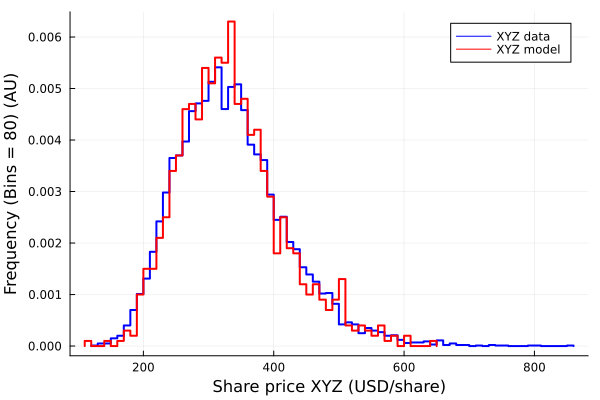

In [16]:
# visualize the price distribution
# fill me in ...
stephist(X[end, 2:end], bins = number_of_bins, normed = :true, lw = 2, c = :blue,
    label = "XYZ data")
stephist!(LNM, bins = number_of_bins, normed = :true, lw = 2, c = :red,
    label = "XYZ model")

xlabel!("Share price XYZ (USD/share)", fontsize=18)
ylabel!("Frequency (Bins = $(number_of_bins)) (AU)", fontsize=18)

In [17]:
# show the parameters, or use the params command (need these for Options question)
d
# See: https://juliastats.org/Distributions.jl/stable/univariate/#StatsAPI.params-Tuple{UnivariateDistribution}

LogNormal{Float64}(μ=5.7836922966946, σ=0.24615616494814035)